In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Load enriched TSLA data
tsla = pd.read_csv("../data/processed/TSLA_enriched.csv", parse_dates=["Date"], index_col="Date")

# Focus only on 'Close' price for univariate forecasting
tsla_close = tsla[['Close']].copy()
tsla_close.head()


,Close
Date,
2015-07-01,17.943333
2015-07-02,18.667999
2015-07-06,18.648001
2015-07-07,17.858667
2015-07-08,16.997334


Train range: 2015-07-01 00:00:00 to 2023-12-29 00:00:00
Test range: 2024-01-02 00:00:00 to 2025-07-30 00:00:00


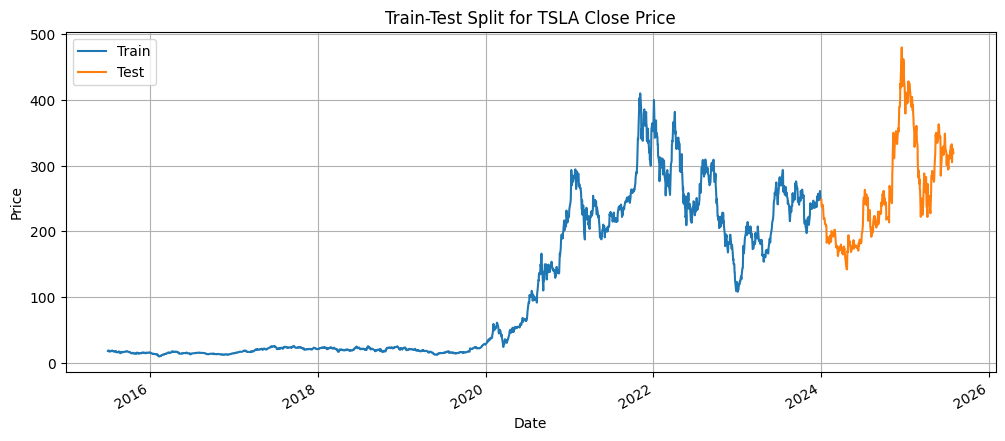

In [2]:
# Chronological split: Train = 2015–2023, Test = 2024–2025
train = tsla_close[tsla_close.index < "2024-01-01"]
test = tsla_close[tsla_close.index >= "2024-01-01"]

print("Train range:", train.index.min(), "to", train.index.max())
print("Test range:", test.index.min(), "to", test.index.max())

plt.figure(figsize=(12, 5))
train['Close'].plot(label="Train")
test['Close'].plot(label="Test")
plt.title("Train-Test Split for TSLA Close Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [3]:
import sys
import os
sys.path.append(os.path.abspath('../src'))
from arima_model import train_arima_model, forecast_arima
# Train ARIMA on training set
model_arima = train_arima_model(train['Close'])


c:\Users\filimon.hailemariam\Downloads\Week 11\GMF-investment-portfolio-management\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\filimon.hailemariam\Downloads\Week 11\GMF-investment-portfolio-management\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\filimon.hailemariam\Downloads\Week 11\GMF-investment-portfolio-management\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\filimon.hailemariam\Downloads\Week 11\GMF-investment-portfolio-management\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1

Best ARIMA order: (0, 1, 0)


c:\Users\filimon.hailemariam\Downloads\Week 11\GMF-investment-portfolio-management\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\filimon.hailemariam\Downloads\Week 11\GMF-investment-portfolio-management\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\filimon.hailemariam\Downloads\Week 11\GMF-investment-portfolio-management\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [4]:
# Forecast the length of the test set
forecast_steps = len(test)
arima_preds = forecast_arima(model_arima, steps=forecast_steps)

# Align with test index
arima_preds.index = test.index


c:\Users\filimon.hailemariam\Downloads\Week 11\GMF-investment-portfolio-management\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\filimon.hailemariam\Downloads\Week 11\GMF-investment-portfolio-management\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


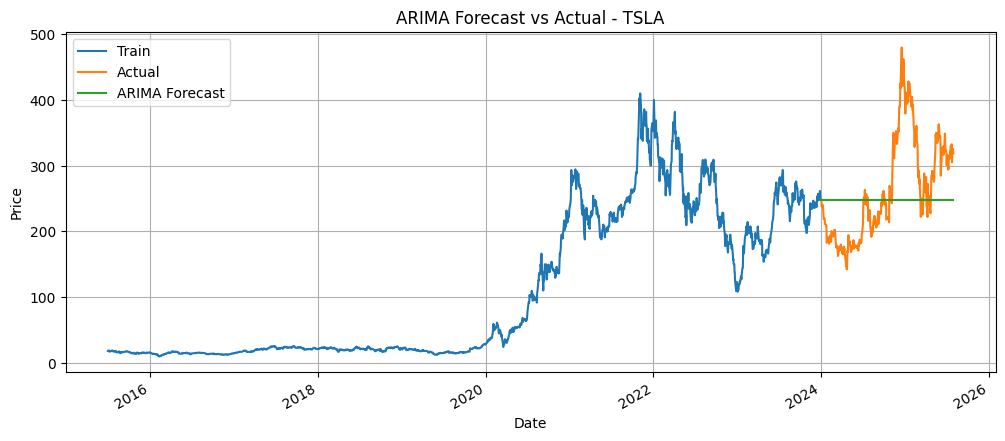

In [5]:
# Plot forecast vs actual
plt.figure(figsize=(12, 5))
train['Close'].plot(label='Train')
test['Close'].plot(label='Actual')
arima_preds.plot(label='ARIMA Forecast')
plt.title("ARIMA Forecast vs Actual - TSLA")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
from sklearn.metrics import mean_squared_error

mae = mean_absolute_error(test['Close'], arima_preds)
rmse = mean_squared_error(test['Close'], arima_preds) ** 0.5  # ✅ Take square root manually
mape = mean_absolute_percentage_error(test['Close'], arima_preds)

print("📊 ARIMA Forecast Performance:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2%}")


📊 ARIMA Forecast Performance:
MAE:  62.97
RMSE: 77.96
MAPE: 24.09%


In [7]:
import joblib
import os

# Ensure folder exists
os.makedirs("../models/saved", exist_ok=True)

# Save ARIMA model
joblib.dump(model_arima, "../models/saved/tsla_arima_model.pkl")
print("✅ ARIMA model saved to models/saved/tsla_arima_model.pkl")


✅ ARIMA model saved to models/saved/tsla_arima_model.pkl


In [9]:
from sklearn.preprocessing import MinMaxScaler
import sys
import os
sys.path.append(os.path.abspath('../src'))
from lstm_model import create_lstm_sequences, build_lstm_model

# Reset index to make LSTM input easier
tsla_lstm = tsla[['Close']].copy()
scaler = MinMaxScaler()
tsla_lstm['Close_scaled'] = scaler.fit_transform(tsla_lstm[['Close']])

# Same chronological split
train_scaled = tsla_lstm[tsla_lstm.index < "2024-01-01"]['Close_scaled'].values
test_scaled = tsla_lstm[tsla_lstm.index >= "2024-01-01"]['Close_scaled'].values

print(f"Train samples: {len(train_scaled)} | Test samples: {len(test_scaled)}")


c:\Users\filimon.hailemariam\Downloads\Week 11\GMF-investment-portfolio-management\.venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\filimon.hailemariam\Downloads\Week 11\GMF-investment-portfolio-management\.venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\filimon.hailemariam\Downloads\Week 11\GMF-investment-portfolio-management\.venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode versio

Train samples: 2140 | Test samples: 395


In [10]:
window_size = 60  # days of lookback
X_train, y_train = create_lstm_sequences(train_scaled, window_size)

# Reshape to [samples, time steps, features] → [N, 60, 1]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

print("X_train shape:", X_train.shape)


X_train shape: (2080, 60, 1)


In [11]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Build model
input_shape = (X_train.shape[1], X_train.shape[2])
model_lstm = build_lstm_model(input_shape)

# Define early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='loss', patience=5)

# Train the model
history = model_lstm.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)


c:\Users\filimon.hailemariam\Downloads\Week 11\GMF-investment-portfolio-management\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0132
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0010
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 7.9964e-04
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 7.4930e-04
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 6.5657e-04
Epoch 6/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 6.1038e-04
Epoch 7/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 5.6538e-04
Epoch 8/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 5.5392e-04
Epoch 9/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 5.2517e-04
Epoch 10/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 5.4851e-04
Epoch 11/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 4.7931e-04
Epoch 12/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 4.5776e-04
Epoch 13/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 4.0497e-04
Epoch 14/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.1334e-04
Epoch 15/30
65/65 ━━━━━

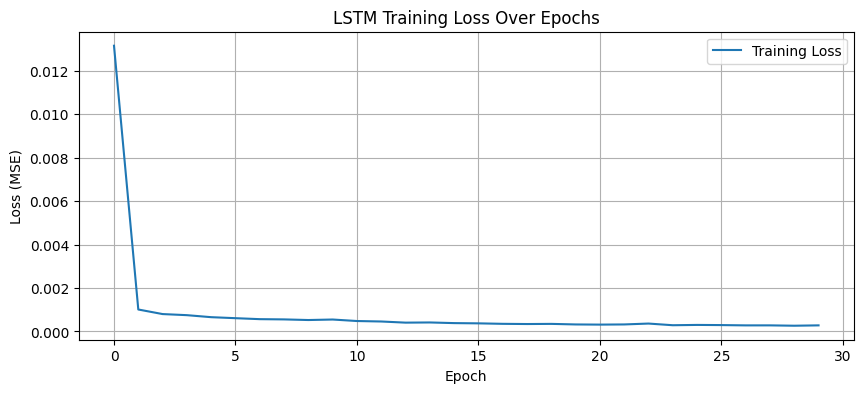

In [12]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.title("LSTM Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
# Combine the last part of training with the test for context
import numpy as np
full_input = np.concatenate((train_scaled[-window_size:], test_scaled))
X_test = []

for i in range(len(test_scaled)):
    X_test.append(full_input[i:i+window_size])

X_test = np.array(X_test).reshape(-1, window_size, 1)

print("X_test shape:", X_test.shape)


X_test shape: (395, 60, 1)
